### DATA PREP

In [12]:
import pandas as pd 
import numpy as np
import warnings
warnings. filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from mlp_support import normalize
from mlp_support import set_global_determinism
set_global_determinism()
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(0) 
seed(0)

In [13]:
#data_test = np.array(pd.read_csv('sensor6_2022.csv')['height (m)'])
# dataset import
df =  pd.read_csv('sensor6_2021.csv')
dfz = df.drop(['time'],axis=1)
df2 = normalize(dfz)
x =df2[df2.columns[0]].to_numpy()
data_size = int(x.shape[0] * .80)
data_train = x[:data_size].flatten()
data_test = x[data_size:].flatten()
data_test.shape

(59,)

In [14]:
def split_stage(series, h_step, f_step):
    x, y = list(), list()
    for i in range(len(series)):
        win_end_indx = i + h_step
        future_indx = win_end_indx + f_step
        if future_indx > len(series):
            break
        series_x, series_y = series[i:win_end_indx], series[win_end_indx:future_indx ]
        x.append(series_x)
        y.append(series_y)
    return np.array(x), np.array(y) 

In [27]:
h_step = 4
f_step = 5
x_train, y_train = split_stage(data_train, h_step , f_step) 
x_train.shape , y_train.shape

((227, 4), (227, 5))

In [28]:
x_test, y_test = split_stage(data_test, h_step , f_step )
x_test.shape, y_test.shape

((51, 4), (51, 5))

### Model boost 

In [29]:
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [30]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,learning_rate=0.3)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Model Evaluation 

In [31]:
def evaluate_model(y_test , y_pred):
    scores = []
    #scores for each day
    for i in range (y_test.shape[1]):
        mse = mean_squared_error(y_test[:,i], y_pred[:,i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    #scores for the whole prediction exercise
    overall_score = 0
    for row in range (y_test.shape[0]):
        for col in range (y_pred.shape[1]):
            overall_score = overall_score + (y_test[row,col]-y_pred[row,col])**2
    overall_score = np.sqrt(overall_score/(y_test.shape[0] * y_pred.shape[1]))
    return  overall_score, scores

In [32]:
yhat = model.predict(x_test)
c = evaluate_model(y_test,yhat)
m = yhat[:, 0]
n = y_test[:,0]
c

(0.070854341178796,
 [0.0399862483674199,
  0.05445816903068895,
  0.08010588279906634,
  0.07415401380738774,
  0.09285109511452219])

In [33]:
df2 = df.tail(len(y_test))
df2[['time']] = df2[['time']].apply(pd.to_datetime, format="%d/%m/%Y")

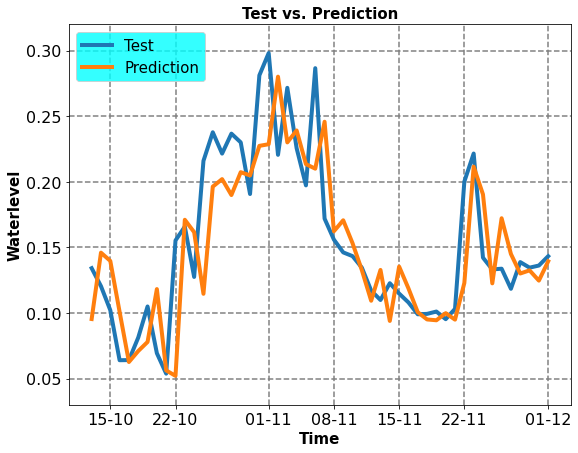

In [11]:
#Plot the output
plt.rcParams['figure.figsize'] = (9,7)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
Test, = plt.plot(df2['time'],n,linewidth=4, label='label1')
Prediction, = plt.plot(df2['time'], m, linewidth=4, label='label1')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('Test vs. Prediction',fontsize=15,weight = 'bold')
ax.set_xlabel('Time',fontsize=15,weight = 'bold')
ax.set_ylabel('Waterlevel',fontsize=15, weight = 'bold')
ax.set_ylim(0.03,0.32)
ax.tick_params(axis='both',labelsize=16)
ax.tick_params(axis = 'x', labelsize = 16)
ax.grid(True)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend(["Test", "Prediction"], loc ="upper left", fancybox=True,facecolor='#01FFFF',prop={'size': 15,  'style': 'normal'})
ax.set(facecolor = "white")
plt.savefig('x2.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()